In [1]:
import os
import os.path as ospath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import glob

from picasso.picasso import io


In [2]:
def load_ring_data_df(dirname, filename):
    file = ospath.join(dirname, filename)

    try: 
        df = pd.read_pickle(file)
    except FileNotFoundError:
        print("No results of previously analyzed datasets were detected.")
        return None
    else: 
        print("Results of previously analyzed datasets were detected.")
        return df
    
def load_data(path):

    try:
        locs, info = io.load_locs(path)
    except io.NoMetadataFileError:
        return None, None, None
    
    try:
        pixelsize = info[1]["Pixelsize"]
    except:  
        print("No pixelsize found in yaml file. Default 130 nm used.")

        
    return locs, info, pixelsize

In [3]:
path = r'Z:\users\kcramer\sporPAINT\FtsZ\FtsZ_picks_all'

fov_id = 28
pick = 30 # group

df_ring_data = load_ring_data_df(path, "ring_data.pkl")
print(df_ring_data.keys())

# radius criterium
dR = 100
perc_on_ring_min = 0.8
perc_inside_ring_max = 0.2
perc_outside_ring_max = 0.2

# angle criterium
N_segments = 12
perc_locs_per_filled_segment_min = 1/N_segments/4 # a segment counts as filled if it contains this fraction of all localizations
perc_segments_filled_min = 0.6 # this fraction of segments has to be filled to accept the ring



Results of previously analyzed datasets were detected.
Index(['fov_id', 'cell_type', 'filename', 'group', 'residual', 'radius',
       'angle_between_ring_and_coverslip', 'Sigma', 'n_events', 'mean_bright',
       'mean_dark', 'fit_bright', 'fit_dark'],
      dtype='object')


In [4]:
analysis_folder = os.path.join(path, 'analysis')
excluded_folder = os.path.join(path, 'analysis', 'excluded_filter')


fov_28_spor_pick_30_ring_0_rot_yz_update.hdf5
angle
(-180.0, -150.0]    0.102553
(-150.0, -120.0]    0.047234
(-120.0, -90.0]     0.062979
(-90.0, -60.0]      0.065957
(-60.0, -30.0]      0.083830
(-30.0, 0.0]        0.183830
(0.0, 30.0]         0.090638
(30.0, 60.0]        0.008936
(60.0, 90.0]        0.048511
(90.0, 120.0]       0.056596
(120.0, 150.0]      0.098298
(150.0, 180.0]      0.150638
Name: angle, dtype: float64
perc_locs_per_segments_filled angle
(-180.0, -150.0]    0.102553
(-150.0, -120.0]    0.047234
(-120.0, -90.0]     0.062979
(-90.0, -60.0]      0.065957
(-60.0, -30.0]      0.083830
(-30.0, 0.0]        0.183830
(0.0, 30.0]         0.090638
(60.0, 90.0]        0.048511
(90.0, 120.0]       0.056596
(120.0, 150.0]      0.098298
(150.0, 180.0]      0.150638
Name: angle, dtype: float64


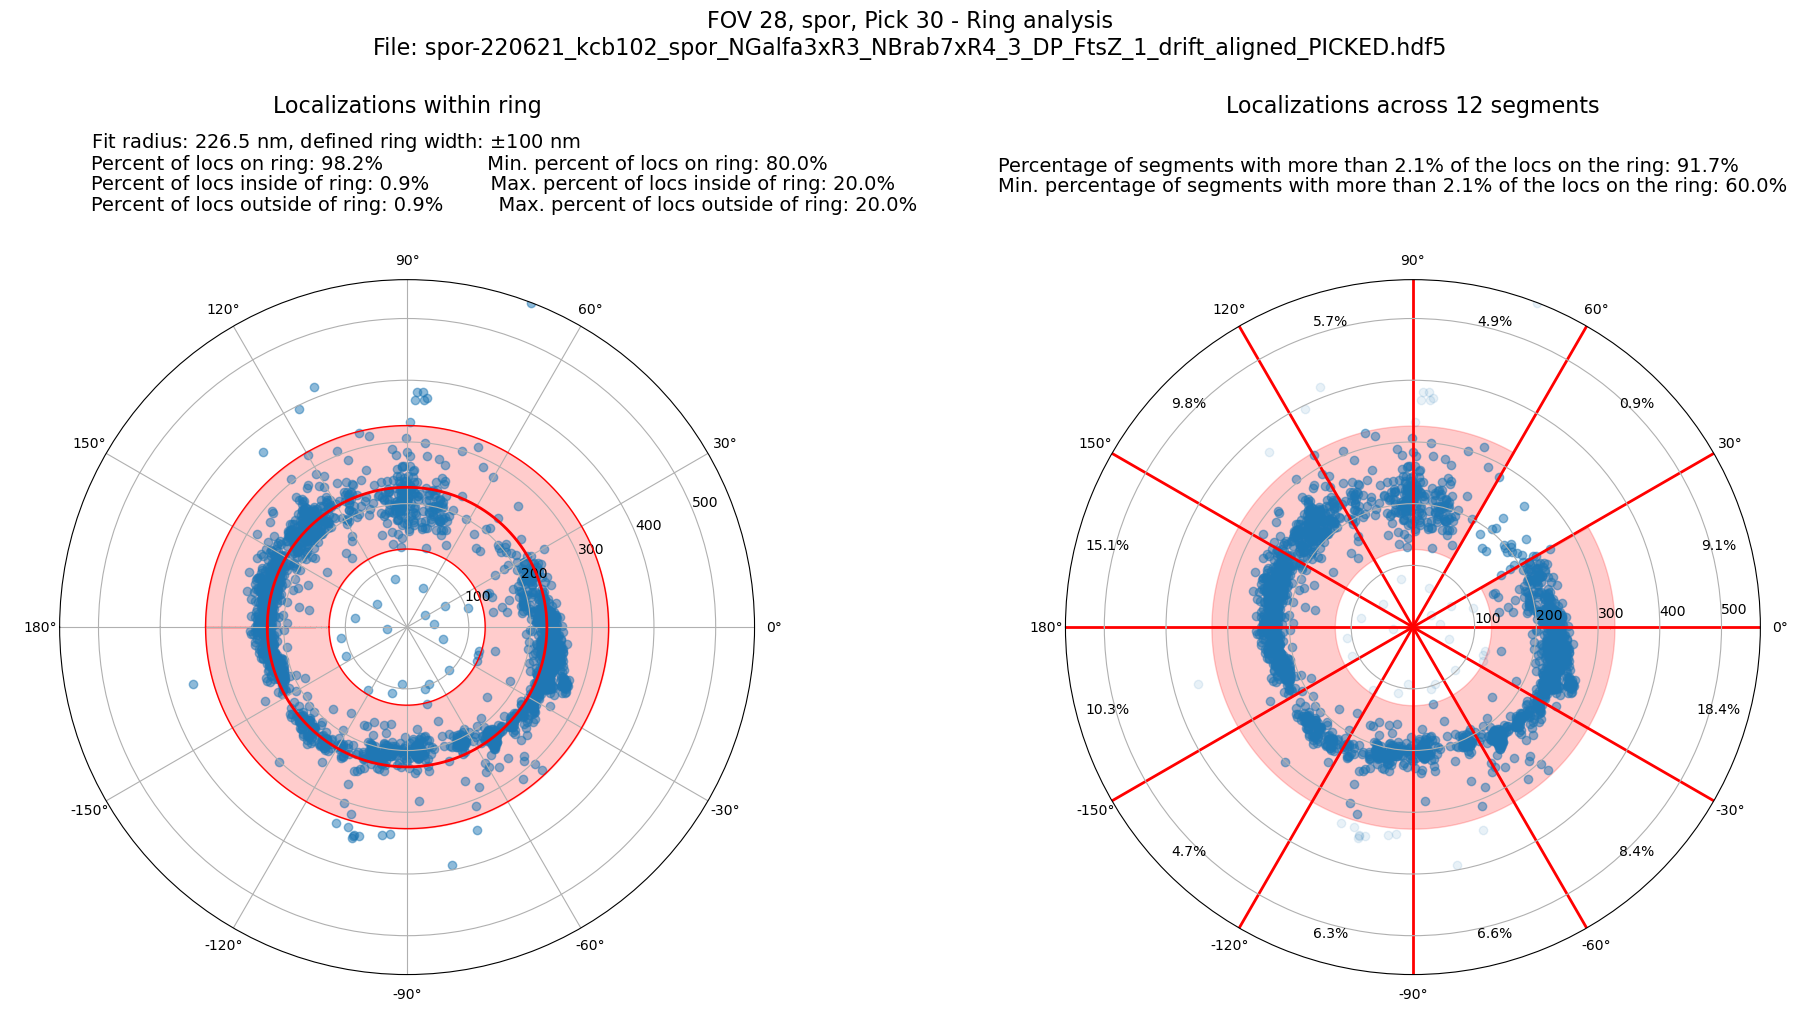

In [6]:



orientation = 'yz' # use yz, but also xy files contain info for filtering



# prepare bins for angle check:
# angles from -180 to 180
bin_width = 360/N_segments
bins = np.arange(-180, 180+bin_width, bin_width)


# add filter_passed column:
df_ring_data['filter_passed'] = np.full(len(df_ring_data), "No")
df_ring_data['filename_ring'] =  'fov_' + df_ring_data['fov_id'].astype(str) +'_' + df_ring_data['cell_type'].astype(str) +'_pick_' + df_ring_data['group'].astype(str) +'_ring_' + '0' +'_rot_' + orientation + '_update.hdf5'
for index, ring in df_ring_data.iterrows():
    if ring['fov_id'] == fov_id and ring['group'] == pick:
        plt.close('all')
        locs, info, pixelsize = load_data(os.path.join(path, 'analysis', 'ring_locs', ring['filename_ring'] ))

        radius_fit = ring['radius']
        radius_min = radius_fit - dR
        radius_max = radius_fit + dR


        N_locs = len(locs)

        ################
        # Check if radius criterium is fulfilled.
        ################

        perc_on_ring = len(locs[(locs['radius']>radius_min) & (locs['radius']<radius_max)]) / N_locs
        perc_inside_ring = len(locs[locs['radius']<radius_min]) / N_locs
        perc_outside_ring = len(locs[locs['radius']>radius_max]) / N_locs

        radius_criterium = perc_on_ring >= perc_on_ring_min and perc_inside_ring <= perc_inside_ring_max and perc_outside_ring <= perc_outside_ring_max

        #print(perc_on_ring, perc_on_ring >= perc_on_ring_min)
        #print(perc_inside_ring, perc_inside_ring <= perc_inside_ring_max)
        #print(perc_outside_ring, perc_outside_ring <= perc_outside_ring_max)
        #print(radius_criterium, radius_criterium)
        #print()

        ################
        # Check if angle criterium is fulfilled.
        ################
        print(ring['filename_ring'])
        df_locs = pd.DataFrame.from_records(locs)

        # consider only locs on ring
        df_locs_not_ring = df_locs[(df_locs['radius']<radius_min) | (df_locs['radius']>radius_max)]
        df_locs_ring = df_locs[(df_locs['radius']>radius_min) & (df_locs['radius']<radius_max)]
        N_locs_ring = len(df_locs_ring)

        perc_locs_per_segment = df_locs_ring['angle'].groupby(pd.cut(df_locs_ring['angle'], bins = bins)).count()/N_locs_ring
        print(perc_locs_per_segment)
        #print(perc_locs_per_filled_segment_min)
        perc_locs_per_segments_filled = perc_locs_per_segment[perc_locs_per_segment>perc_locs_per_filled_segment_min]
        perc_segments_filled = len(perc_locs_per_segments_filled)/N_segments
        print('perc_locs_per_segments_filled', perc_locs_per_segments_filled)
        #print('perc_segments_filled', perc_segments_filled)
        #print('perc_segments_filled_min', perc_segments_filled_min)

        angle_criterium = perc_segments_filled >= perc_segments_filled_min
        #print(angle_criterium)
        #print()



        ################
        # Plot
        ################    

        # set up plot illustrating analysis parameters
        fig = plt.figure(figsize=(20, 10), constrained_layout=True)
        gs = fig.add_gridspec(1,2)
        fig.suptitle(("FOV {}, {}, Pick {} - Ring analysis\n"
                      "File: {}\n").format(ring['fov_id'], ring['cell_type'] , ring['group'], ring['filename']), 
                     fontsize=16, 
                     ha="center")

        # set maximum radius for plot such that 99% of locs are shown
        cutoff = 1

        radius_sort = np.sort(locs['radius'])
        radius_limit = radius_sort[int(cutoff*len(radius_sort))-1]

        ## ring criterium
        ax_1 = fig.add_subplot(gs[0, 0], projection='polar')

        ax_1.set_xticks(bins[1:]/180*np.pi)
        ax_1.set_thetalim(-np.pi,np.pi)

        #ring of fit radius
        coords_angle_fit = np.arange(-np.pi,np.pi,0.01)
        coords_radius_fit = np.full(len(coords_angle_fit), radius_fit)
        coords_radius_min = np.full(len(coords_angle_fit), radius_min)
        coords_radius_max = np.full(len(coords_angle_fit), radius_max)

        ax_1.fill_between(coords_angle_fit,radius_min, radius_max, color='red', alpha=0.2)

        ax_1.plot(coords_angle_fit, coords_radius_fit, c='red', lw=2)
        ax_1.plot(coords_angle_fit, coords_radius_min, c='red', lw=1)
        ax_1.plot(coords_angle_fit, coords_radius_max, c='red', lw=1)

        # locs
        ax_1.scatter(locs['angle']/180*np.pi, locs['radius'], alpha=0.5)


        # set maximum radius for plot such that 99% of locs are shown
        ax_1.set_rmax(radius_limit)

        ax_1.set_title('Localizations within ring\n\n\n\n\n', fontsize = 16)

        annotate_y = 0.85
        plt.annotate("Fit radius: {:.1f} nm, defined ring width: $\pm${:.0f} nm\n".expandtabs().format(radius_fit,dR),xy=(0.05,annotate_y-0.02), xycoords = 'subfigure fraction',fontsize=14)
        plt.annotate("Percent of locs on ring: {:.1f}% \t\t Min. percent of locs on ring: {:.1f}%\n".expandtabs().format(perc_on_ring*100,perc_on_ring_min*100),xy=(0.05,annotate_y-0.04), xycoords = 'subfigure fraction',fontsize=14)
        plt.annotate("Percent of locs inside of ring: {:.1f}%  \t Max. percent of locs inside of ring: {:.1f}%\n".expandtabs().format(perc_inside_ring*100,perc_inside_ring_max*100),xy=(0.05,annotate_y-0.06), xycoords = 'subfigure fraction',fontsize=14)
        plt.annotate("Percent of locs outside of ring: {:.1f}% \t Max. percent of locs outside of ring: {:.1f}%\n".expandtabs().format(perc_outside_ring*100,perc_outside_ring_max*100),xy=(0.05,annotate_y-0.08), xycoords = 'subfigure fraction',fontsize=14)




        ## angle criterium
        ax_2 = fig.add_subplot(gs[0, 1], projection='polar')

        # segments
        ax_2.set_xticks(bins[1:]/180*np.pi)
        ax_2.set_thetalim(-np.pi,np.pi)
        #ax_2.tick_params(axis='x', width = 5, color = 'red')
        ax_2.xaxis.grid(linewidth=2, color = 'red')

        # filled ring segments
        for segment in perc_locs_per_segments_filled.index:
            coords_angle_segment = np.arange(segment.left/180*np.pi,segment.right/180*np.pi,0.01)
            ax_2.fill_between(coords_angle_segment,radius_min, radius_max, color='red', alpha=0.2)

        #ax_2.annotate(text = 'Hello', xy = (np.pi,500))
        for segment in perc_locs_per_segment.index:
            dangle = segment.right-segment.left
            angle_annotate = (segment.right-dangle/2)/180*np.pi
            ax_2.annotate(text = "{:.1f}%".format(perc_locs_per_segment[segment]*100),xy=(angle_annotate,radius_limit-50), ha='center', va='center')

        # locs
        ax_2.scatter(df_locs_not_ring['angle']/180*np.pi, df_locs_not_ring['radius'], alpha=0.1, c='#1f77b4')
        ax_2.scatter(df_locs_ring['angle']/180*np.pi, df_locs_ring['radius'], alpha=0.5, c='#1f77b4')

        # set maximum radius for plot such that 99% of locs are shown
        ax_2.set_rmax(radius_limit)

        ax_2.set_rlabel_position(2)

        ax_2.set_title('Localizations across {:.0f} segments\n\n\n\n\n'.format(N_segments), fontsize = 16)

        plt.annotate("Percentage of segments with more than {:.1f}% of the locs on the ring: {:.1f}% ".expandtabs().format(perc_locs_per_filled_segment_min*100,perc_segments_filled*100),xy=(0.55,annotate_y-0.02), xycoords = 'subfigure fraction',fontsize=14)
        plt.annotate("Min. percentage of segments with more than {:.1f}% of the locs on the ring: {:.1f}% ".expandtabs().format(perc_locs_per_filled_segment_min*100, perc_segments_filled_min*100),xy=(0.55,annotate_y-0.04), xycoords = 'subfigure fraction',fontsize=14)

        ################
        # Save result of criteria check in ring_data dataframe
        ################


        filename_base = 'fov_' + str(ring['fov_id']) +'_' + ring['cell_type'] +'_pick_' + str(ring['group'])
        filename_result =  filename_base +'_filter_replot.png'
        fig.savefig(os.path.join(analysis_folder, filename_result), dpi=300, format="png")
        filename_result =  filename_base +'_filter_replot.pdf'
        fig.savefig(os.path.join(analysis_folder, filename_result), dpi=300, format="pdf")

